In [4]:
#load all the necessary libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
#ENSO table to be used to merge with hurricane data
import pandas as pd

# Define the file path
file_path = "enso_data.txt"

# Load the .txt file
df_ENSO = pd.read_csv(file_path, sep=r'\s+', header=None)

# Rename columns
df_ENSO.columns = ["Year", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Remove non-numeric rows (e.g., headers, footers)
df_ENSO = df_ENSO[df_ENSO["Year"].astype(str).str.match(r'^\d{4}$')]

# Convert Year to integer
df_ENSO["Year"] = df_ENSO["Year"].astype(int)

df_ENSO_long = df_ENSO.melt(id_vars=["Year"], var_name="Month", value_name="SST_Anomaly")

In [15]:
#Hurricane data taken for North American basin 
import pandas as pd

# Define file path
file_path = "../project1/ibtracs.NA.csv"

df_na_hurricanes = pd.read_csv(file_path, low_memory=False)

# Select relevant columns
df_clean = df_na_hurricanes.loc[:, ["SID", "SEASON", "ISO_TIME", "LAT", "LON", "USA_WIND"]].copy()

# Rename columns for clarity
df_clean.columns = ["Storm_ID", "Year", "ISO_Time", "Latitude", "Longitude", "Storm_Intensity"]

df_clean["ISO_Time"] = pd.to_datetime(df_clean["ISO_Time"], format="%Y-%m-%d %H:%M:%S", errors="coerce")

# ✅ Check the datatype of ISO_Time BEFORE conversion
print("\nBefore conversion, ISO_Time dtype:", df_clean["ISO_Time"].dtype)

# ✅ Convert ISO_Time to datetime format
df_clean["ISO_Time"] = pd.to_datetime(df_clean["ISO_Time"], errors="coerce")

# ✅ Check again to confirm conversion worked
print("\nAfter conversion, ISO_Time dtype:", df_clean["ISO_Time"].dtype)

# Drop rows where conversion failed
df_clean = df_clean.dropna(subset=["ISO_Time"])

# ✅ Extract Month safely (after confirming it's datetime)
df_clean["Month"] = df_clean["ISO_Time"].dt.month.astype(int)

# Convert Month from number to text for merging with ENSO
month_map = {
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
    7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
}
df_clean["Month"] = df_clean["Month"].map(month_map)

# Convert Year to integer for merging
df_clean["Year"] = df_clean["Year"].astype(int)

# Save the cleaned dataset
df_clean.to_csv("../project1/hurricane_cleaned.csv", index=False)



Before conversion, ISO_Time dtype: datetime64[ns]

After conversion, ISO_Time dtype: datetime64[ns]
        Storm_ID  Year            ISO_Time Latitude Longitude Storm_Intensity  \
1  1851175N26270  1851 1851-06-23 12:00:00     26.1     -90.4                   
2  1851175N26270  1851 1851-06-23 15:00:00     26.2     -90.7                   
3  1851175N26270  1851 1851-06-23 18:00:00     26.3     -91.0                   
4  1851175N26270  1851 1851-06-23 21:00:00     26.4     -91.3                   
5  1851175N26270  1851 1851-06-24 00:00:00     26.5     -91.6                   

  Month  
1   Jun  
2   Jun  
3   Jun  
4   Jun  
5   Jun  

✅ Cleaned Hurricane dataset with Month extracted successfully!


In [19]:
#merge ENSO and hurricane data together
import pandas as pd

# Load ENSO dataset
enso_path = "../project1/nino_labeled.csv"
enso_df = pd.read_csv(enso_path)

# Merge hurricane data with ENSO data on Year & Month
merged_df = df_clean.merge(enso_df, on=["Year", "Month"], how="left")

# Save merged dataset
merged_df.to_csv("../project1/merged_data.csv", index=False)


        Storm_ID  Year            ISO_Time Latitude Longitude Storm_Intensity  \
0  1851175N26270  1851 1851-06-23 12:00:00     26.1     -90.4                   
1  1851175N26270  1851 1851-06-23 15:00:00     26.2     -90.7                   
2  1851175N26270  1851 1851-06-23 18:00:00     26.3     -91.0                   
3  1851175N26270  1851 1851-06-23 21:00:00     26.4     -91.3                   
4  1851175N26270  1851 1851-06-24 00:00:00     26.5     -91.6                   

  Month  SST_Anomaly ENSO_Phase  
0   Jun          NaN        NaN  
1   Jun          NaN        NaN  
2   Jun          NaN        NaN  
3   Jun          NaN        NaN  
4   Jun          NaN        NaN  

✅ Hurricane-ENSO dataset merged successfully!


In [33]:
#ENSO table to be used for ENSO visualization

# Load ENSO data
file_path = "enso_data.txt"  # Adjust path if needed
df = pd.read_csv(file_path, sep=r'\s+', header=None)

# Rename columns
df.columns = ["Year", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Remove non-numeric rows (e.g., headers, footers)
df = df[df["Year"].astype(str).str.match(r'^\d{4}$')]

# Convert Year to integer
df["Year"] = df["Year"].astype(int)

# Convert to long format
df_long = df.melt(id_vars=["Year"], var_name="Month", value_name="SST_Anomaly")

# Convert SST_Anomaly to numeric
df_long["SST_Anomaly"] = pd.to_numeric(df_long["SST_Anomaly"], errors="coerce")

# Sort values (important for applying 5-month rule)
df_long = df_long.sort_values(by=["Year", "Month"]).reset_index(drop=True)

# Initialize ENSO phase column
df_long["ENSO_Phase"] = "Neutral"

# Function to apply 5-month rule
def detect_enso_events(df):
    consecutive_count = 0
    current_phase = "Neutral"
    
    for i in range(len(df)):
        anomaly = df.loc[i, "SST_Anomaly"]

        # Determine the phase for this month
        if anomaly >= 0.5:
            phase = "El Niño"
        elif anomaly <= -0.5:
            phase = "La Niña"
        else:
            phase = "Neutral"

        # If we are continuing the same phase, increase count
        if phase == current_phase:
            consecutive_count += 1
        else:
            # If we switch phases, reset the counter
            consecutive_count = 1
            current_phase = phase

        # If phase has lasted for at least 5 months, apply to previous months
        if consecutive_count >= 5:
            for j in range(i - 4, i + 1):
                df.loc[j, "ENSO_Phase"] = current_phase  # Apply to previous 5 months

    return df

# Apply 5-month rule
df_long = detect_enso_events(df_long)
df_long.to_csv("../project1/nino_labeled.csv", index=False)
df_long

,Year,Month,SST_Anomaly,ENSO_Phase
0,1870,Apr,-0.81,La Niña
1,1870,Aug,-0.88,La Niña
2,1870,Dec,-0.79,La Niña
3,1870,Feb,-1.20,La Niña
4,1870,Jan,-1.00,La Niña
...,...,...,...,...
1843,2023,Mar,-0.13,Neutral
1844,2023,May,0.47,Neutral
1845,2023,Nov,2.01,Neutral
1846,2023,Oct,1.59,Neutral


   Year  SST_Anomaly ENSO_Phase
0  1870    -0.928333    La Niña
1  1871    -0.448333    Neutral
2  1872    -0.712500    La Niña
3  1873    -0.695000    La Niña
4  1874    -1.067500    La Niña


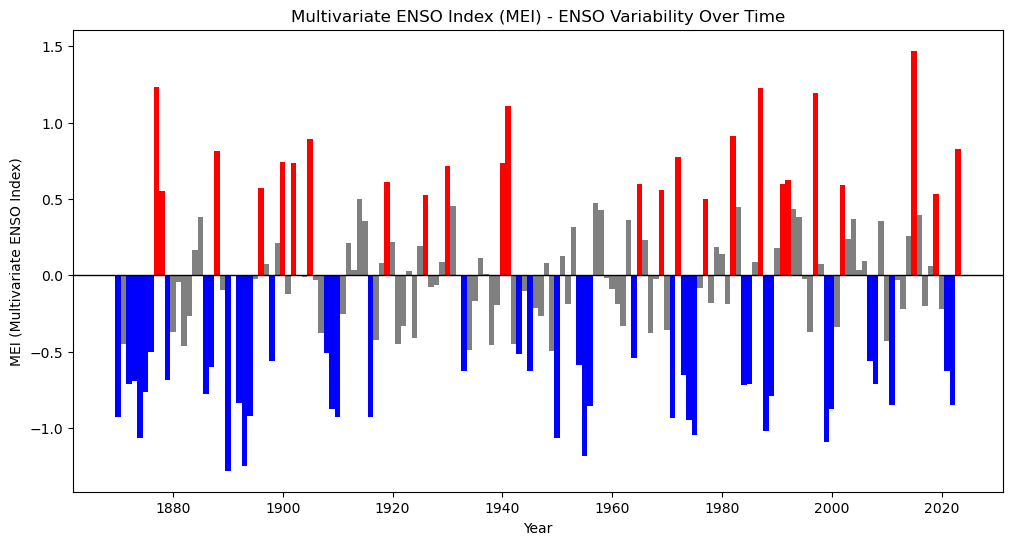

In [37]:

# Load labeled ENSO dataset
file_path = "../project1/nino_labeled.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Aggregate by Year (Average SST anomaly per year)
df_yearly = df.groupby("Year")["SST_Anomaly"].mean().reset_index()

# Classify ENSO Phase for yearly data
def classify_enso(value):
    if value >= 0.5:
        return "El Niño"
    elif value <= -0.5:
        return "La Niña"
    else:
        return "Neutral"

df_yearly["ENSO_Phase"] = df_yearly["SST_Anomaly"].apply(classify_enso)

# Display first few rows to confirm classification
print(df_yearly.head())

# Set figure size
plt.figure(figsize=(12, 6))

# Plot positive bars for El Niño (Red)
plt.bar(df_yearly["Year"], df_yearly["SST_Anomaly"], color=df_yearly["SST_Anomaly"].apply(lambda x: "red" if x >= 0.5 else "blue" if x <= -0.5 else "gray"), width=1.0)

# Add a horizontal line at y=0
plt.axhline(0, color="black", linewidth=1)

# Labels and title
plt.xlabel("Year")
plt.ylabel("MEI (Multivariate ENSO Index)")
plt.title("Multivariate ENSO Index (MEI) - ENSO Variability Over Time")

# Show the plot
plt.show()
